<a href="https://colab.research.google.com/github/MathHenrique065/Brain_Diseases-ViT_Transfer_Learning_basic_model/blob/main/DIO_Transfer_Learning_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning Project

# Dataset: Detecting Alzheimer's and Parkinson Disease

In [1]:
%matplotlib inline
import numpy as np
import keras
import tensorflow.keras as tf
import pandas as pd

import os
import zipfile
import shutil
import random
#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"




from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow



from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation,   GlobalAveragePooling2D, Conv2D, MaxPooling2D
from keras.models import Model

## Extracting the Dataset

In [2]:
!pip install opendatasets

In [3]:
import opendatasets as od

In [4]:
od.download("https://www.kaggle.com/datasets/farjanakabirsamanta/alzheimer-diseases-3-class")

Skipping, found downloaded files in "./alzheimer-diseases-3-class" (use force=True to force download)


## Separating in Folders

In [5]:

# Caminho para o diretório baixado
downloaded_folder_path = '/content/alzheimer-diseases-3-class'

# Caminho para o diretório de saída para o pré-processamento
output_folder_path = '/content/preprocessed_data'

# Defina class labels
class_labels = ['CONTROL', 'AD', 'PD']

# Crie pastas de saída para conjuntos de treinamento, validação e teste
for label in class_labels:
    os.makedirs(os.path.join(output_folder_path, 'train', label), exist_ok=True)
    os.makedirs(os.path.join(output_folder_path, 'val', label), exist_ok=True)
    os.makedirs(os.path.join(output_folder_path, 'test', label), exist_ok=True)

# Divida os dados em conjuntos de treinamento, validação e teste
for label in class_labels:
    image_folder = os.path.join(downloaded_folder_path, '3_cls/train', label)
    images = os.listdir(image_folder)
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
    train_images, val_images = train_test_split(train_images, test_size=0.2, random_state=42)

    # Copie as imagens para as pastas correspondentes
    for image in train_images:
        shutil.copy(os.path.join(image_folder, image), os.path.join(output_folder_path, 'train', label))
    for image in val_images:
        shutil.copy(os.path.join(image_folder, image), os.path.join(output_folder_path, 'val', label))
    for image in test_images:
        shutil.copy(os.path.join(image_folder, image), os.path.join(output_folder_path, 'test', label))



## Data Generators

In [74]:
# Set up data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)


In [75]:

train_generator = train_datagen.flow_from_directory(
    os.path.join(output_folder_path, 'train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(output_folder_path, 'val'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 4143 images belonging to 3 classes.
Found 1037 images belonging to 3 classes.


In [8]:

# Split a portion of the training data for testing
train_images, test_images, train_labels, test_labels = train_test_split(
    train_generator.filepaths,
    train_generator.labels,
    test_size=0.2,
    random_state=42
)

In [9]:

# Convert numerical labels to string labels
train_labels_str = [str(label) for label in train_labels]
test_labels_str = [str(label) for label in test_labels]

In [10]:

# Set up a separate data generator for testing
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    pd.DataFrame({'filename': test_images, 'class': test_labels_str}),
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 829 validated image filenames belonging to 3 classes.


In [11]:
# Separando em inputs (x) e labels (y)
train_x, train_y = next(train_generator)
val_x, val_y = next(val_generator)

test_x, test_y = next(test_generator)

# Training the model

### Training a customized CNN model



In [170]:

# Define EfficientNet model using TensorFlow and Keras

base_model = keras.applications.EfficientNetB0(include_top=False, input_shape=(224, 224, 3), weights='imagenet')

model = Sequential([
    base_model,

    GlobalAveragePooling2D(),

    Dense(256, activation='relu'),
    Dropout(0.5),

    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.1),

    Dense(3, activation='softmax')
])

In [171]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_10 (Rescaling)    (None, 224, 224, 3)          0         ['input_15[0][0]']            
                                                                                                  
 normalization_5 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_10[0][0]']        
 tion)                                                                                            
                                                                                                  
 rescaling_11 (Rescaling)    (None, 224, 224, 3)          0         ['normalization_5

In [175]:
print("Input dimensions: ", train_x.shape[1:])

Input dimensions:  (224, 224, 3)


In [36]:
# build the network
print("Input dimensions: ", train_x.shape[1:])


model = Sequential([


        Conv2D(32, (3, 3), input_shape=train_x.shape[1:]),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(32, (3, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),



        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),

        Dense(128, activation='relu'),
        Dropout(0.3),

        Dense(3, activation='softmax'),


])


model.summary()

Input dimensions:  (224, 224, 3)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 activation (Activation)     (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout) 

### Callbacks, Optimization & Loss functions

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
np.random.seed(0)

In [ ]:
OPT = keras.optimizers.AdamW(learning_rate=0.001)

In [ ]:
LOSS = "categorical_crossentropy"

In [ ]:
# Define callbacks.
checkpoint = ModelCheckpoint('best_model',
                                      monitor='val_accuracy',
                                      mode='max',
                                      save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15)


In [ ]:
CALLBACKS = [checkpoint, early_stopping]

### Metrics

In [37]:
from tensorflow.keras import metrics

In [38]:
from tensorflow_addons.metrics import F1Score

In [39]:
metrics_model =   ['accuracy',
                    metrics.Precision(name='precision'),
                    metrics.Recall(name='recall'),
                    metrics.AUC(name='auc'),
                    F1Score(num_classes=3, name='f1_score')]

### Compilando o Modelo

In [40]:
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
# You can then compile and train the model using the generated data generators
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.compile(loss=LOSS,
              optimizer=OPT,
              metrics=metrics_model
              )

In [41]:

# model.fit(, epochs=epochs, validation_data=val_generator)



history = model.fit(train_x, train_y, batch_size=16, epochs=50, validation_data=(val_x, val_y))



Epoch 1/50
2/2 [==============================] - 9s 624ms/step - loss: 0.9495 - accuracy: 0.4688 - precision: 0.6667 - recall: 0.1250 - auc: 0.7141 - f1_score: 0.3387 - val_loss: 0.2623 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000 - val_f1_score: 0.3333
Epoch 2/50
2/2 [==============================] - 0s 104ms/step - loss: 1.0005 - accuracy: 0.5000 - precision: 0.5161 - recall: 0.5000 - auc: 0.7532 - f1_score: 0.2862 - val_loss: 0.5885 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000 - val_f1_score: 0.3333
Epoch 3/50
2/2 [==============================] - 0s 110ms/step - loss: 0.9136 - accuracy: 0.5625 - precision: 0.6000 - recall: 0.5625 - auc: 0.7793 - f1_score: 0.3772 - val_loss: 0.7920 - val_accuracy: 0.8125 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8848 - val_f1_score: 0.2989
Epoch 4/50
2/2 [==============================] - 0s 107ms/step - loss: 0.8663 - accuracy: 0.4688 - prec

Let's plot the validation loss and validation accuracy over time.

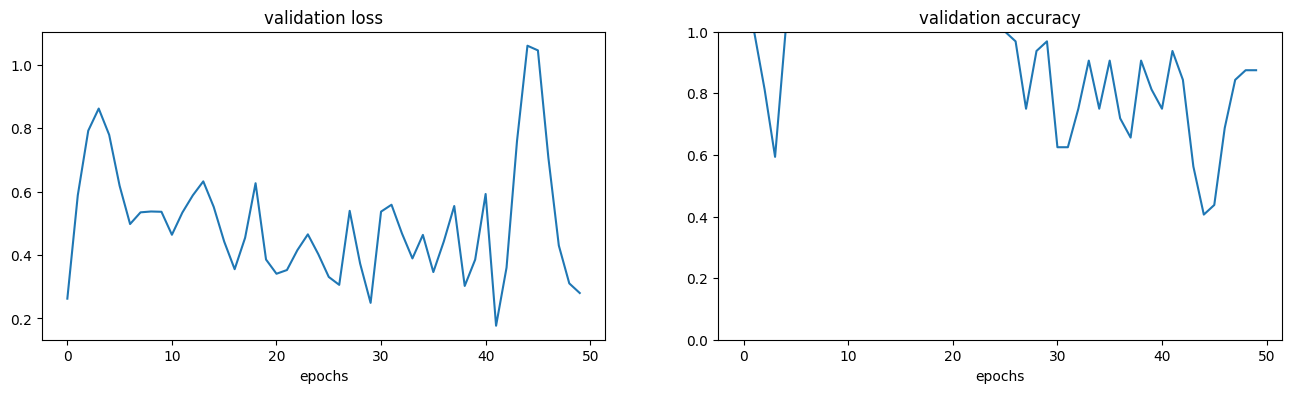

In [42]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [43]:
result = model.evaluate(test_x, test_y, verbose=0)
print('Test result:', result)

Test result: [3.7704596519470215, 0.46875, 0.46875, 0.46875, 0.56591796875, array([0.59999996, 0.        , 0.75      ], dtype=float32)]


In [44]:
print('Test loss:', result[0])
print('Test accuracy:', result[1])  # Assuming accuracy is the second metric

Test loss: 3.7704596519470215
Test accuracy: 0.46875


## Transfer Learning - ViT

In [45]:
pip install -U tensorflow-addons

In [46]:
import tensorflow_addons as tfa

In [47]:
!pip install --quiet vit-keras

from vit_keras import vit, visualize
import tensorflow_addons as tfa

In [59]:
from keras.utils import to_categorical

In [60]:
train_y_one_hot = to_categorical(train_y, num_classes=3)
val_y_one_hot = to_categorical(val_y, num_classes=3)

In [48]:
#vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
#vgg.summary()


ViT_model = vit.vit_b16(  #vit.vit_b16
        image_size = 224,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 3)

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


In [49]:
ViT_model.summary()

Model: "vit-b16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 14, 14, 768)       590592    
                                                                 
 reshape_1 (Reshape)         (None, 196, 768)          0         
                                                                 
 class_token (ClassToken)    (None, 197, 768)          768       
                                                                 
 Transformer/posembed_input  (None, 197, 768)          151296    
  (AddPositionEmbs)                                              
                                                                 
 Transformer/encoderblock_0  ((None, 197, 768),        7087872   
  (TransformerBlock)          (None, 12, None, None)       

In [83]:
model = keras.Sequential([
    ViT_model,  # Include the ViT model as the base

    Flatten(),  # Flatten the output of ViT

    Dense(64, activation='relu'),
    Dropout(0.1),

    Dense(3, activation='softmax')  # Output layer with 3 classes
])

In [84]:
model.compile(loss=LOSS, optimizer=OPT,
              metrics=metrics_model)

In [ ]:
history2 = model.fit(train_generator,
                     batch_size=128, epochs=50,
                     validation_data=val_generator)

Epoch 1/50
130/130 [==============================] - 234s 1s/step - loss: 0.7381 - accuracy: 0.5272 - precision: 0.5308 - recall: 0.5120 - auc: 0.7679 - f1_score: 0.5723 - val_loss: 0.6857 - val_accuracy: 0.5352 - val_precision: 0.5352 - val_recall: 0.5352 - val_auc: 0.7989 - val_f1_score: 0.4933
Epoch 2/50
130/130 [==============================] - 188s 1s/step - loss: 0.7063 - accuracy: 0.5223 - precision: 0.5235 - recall: 0.5117 - auc: 0.7736 - f1_score: 0.5725 - val_loss: 0.6782 - val_accuracy: 0.5419 - val_precision: 0.5419 - val_recall: 0.5419 - val_auc: 0.7983 - val_f1_score: 0.4847
Epoch 3/50
130/130 [==============================] - 188s 1s/step - loss: 0.7065 - accuracy: 0.5274 - precision: 0.5257 - recall: 0.4984 - auc: 0.7742 - f1_score: 0.5755 - val_loss: 0.6920 - val_accuracy: 0.6181 - val_precision: 0.6704 - val_recall: 0.2334 - val_auc: 0.7937 - val_f1_score: 0.6305
Epoch 4/50
130/130 [==============================] - 188s 1s/step - loss: 0.7039 - accuracy: 0.5390 - 

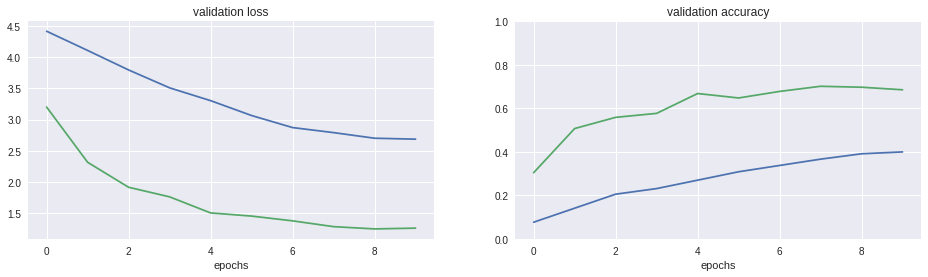

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [105]:
result = ViT_model.evaluate(test_x, test_y, verbose=0)
print('Test result:', result)

Test result: [1.137289047241211, 0.46875]


In [ ]:
# helper function to load image and return it and input vector
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [ ]:
img, x = get_image('101_ObjectCategories/airplanes/image_0003.jpg')
probabilities = model_new.predict([x])


0.6425913


### Transfer Learning - Mamba Network (Work in Progress)